In [178]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn #for datasets

from sklearn.datasets import make_blobs
X, t = make_blobs(n_samples=[400,400,400, 400, 400], centers=[[0,1],[4,1],[8,1],[2,0],[6,0]], 
                  n_features=2, random_state=2019, cluster_std=0.6)

indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)

X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_train = t[indices[:1000]]
t_val = t[indices[1000:1500]]
t_test = t[indices[1500:]]

t2_train = t_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_val >= 3).astype('int')
t2_test = (t_test >= 3).astype('int')

In [179]:
def standardScaler(dataset): 
    
    scaled_data_set = (dataset - np.min(X_train))/(np.max(X_train)-np.min(X_train))
    
    return scaled_data_set


def standardScaler3(dataset): 
    min_on_training = X_train.min(axis=0)
    range_of_training = (X_train - min_on_training).max(axis=0)
    
    data_scaled = (dataset- min_on_training) /(range_of_training)
    return data_scaled

def standardScaler2(data_set): 
    
    scaled_data_set = (data_set - np.average(X_train, axis=0))/(np.std(X_train, axis=0))
    
    return scaled_data_set


def one_hot_encode(Y):
    n_labels = Y.shape[0]
    n_classes = 5
    encoded_Y = np.zeros((n_labels, n_classes))
    for i in range(n_labels):
        label = Y[i]
        encoded_Y[i][label] = 1
    return encoded_Y

In [180]:
def plot_decision_regions(X, t, clf=[], size=(8,6)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    #print(y_min, y_max)
    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'Paired')

    plt.scatter(X[:,0], X[:,1], c=t, s=20.0, cmap='Paired')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")

[ 3.91346059 -0.4630757 ]


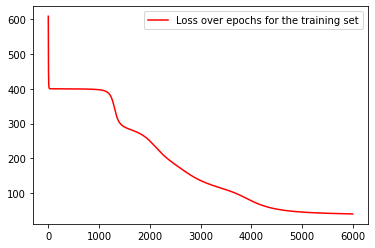

0.93


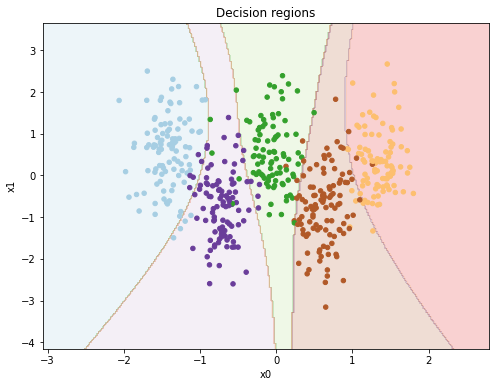

In [275]:
class MultiLP: 
    
    def __init__(self, input_data, target_data, dim_hidden, dim_hidden2, dim_hidden3, beta=1): 
        """
        The neural network presented here is my first ever written with more than 
        one hidden layer. The implementation is purely based on intuition, and suffers 
        some minor issues of instability as a result of that.
        """
        self.dim_in = input_data.shape[1]
        self.dim_out = target_data.shape[1]
        self.hidden_nodes = dim_hidden
        self.hidden_nodes2 = dim_hidden2 
        self.hidden_nodes3 = dim_hidden3
        self.target = target_data
        self.n_examples = input_data.shape[0]
        self.beta = beta 
        
        # Initializing the weights could've been done straight away without a method,
        # but since we've written a method for it already, it'll be faster
        self.hidden_weights = (np.random.rand(self.dim_in+1,self.hidden_nodes)-0.5)*2/np.sqrt(self.dim_in)
        self.hidden_weights2 = (np.random.rand(self.hidden_nodes2+1,self.hidden_nodes2)-0.5)*2/np.sqrt(self.hidden_nodes)
        self.hidden_weights3 = (np.random.rand(self.hidden_nodes3+1,self.hidden_nodes3)-0.5)*2/np.sqrt(self.hidden_nodes2)
        
        # Pay attention to the fact that we add 1 to the first dimension,
        # and the reason for that is that we usually add bias to the output 
        # of the hidden nodes.
        self.output_weights = (np.random.rand(self.hidden_nodes+1,self.dim_out)-0.5)*2/np.sqrt(self.hidden_nodes3)
        
    def activation(self, z):
        return 1. / (1. + np.exp(-z*self.beta))
    
    def back_propagation(self, target):
        delta_output = self.beta*(self.output-target)*self.output*(1-self.output)
        delta_hidden3 = self.hidden_act3*self.beta*(1-self.hidden_act3)*(delta_output@self.output_weights.T)
        delta_hidden2 = self.hidden_act2*self.beta*(1-self.hidden_act2)*(delta_hidden3[:,1:]@self.hidden_weights3.T)    
        delta_hidden = self.hidden_act*self.beta*(1-self.hidden_act)*(delta_hidden2[:,1:]@self.hidden_weights2.T)
   
        return delta_output, delta_hidden3, delta_hidden2, delta_hidden
    
    def update_weights(self, inputs, g1, g2, g3, g4, eta): 
        self.hidden_weights -= ((add_bias(inputs).T@g1) * eta )
        self.hidden_weights2 -= ((self.hidden_act.T@g2) * eta )
        self.hidden_weights3 -= ((self.hidden_act2.T@g3) * eta )
        self.output_weights -= ((self.hidden_act3.T@g4) * eta )
    
    def loss(self,output, targets): 
        """
        Calculating the loss by computing the difference betwenn predicted
        values and the target values, and the taking the square of it. 
        """
          # -np.average((1/2)*(X@self.weights-Y)**2)
        return (0.5)*np.sum((output -targets)**2)
        
    def forward(self, inputs): 
        
        # Again inspired by Marsland and O'Reilly, i save the hidden outputs 
        # so that I don't need to calculate it for each time
        net_hidden_input = add_bias(inputs)@self.hidden_weights 
        hidden_activation = self.activation(net_hidden_input)
        self.hidden_act = add_bias(hidden_activation)
        
        net_hidden2_input = self.hidden_act@self.hidden_weights2
        hidden_activation2 = self.activation(net_hidden2_input)
        self.hidden_act2 = add_bias(hidden_activation2)
        
        net_hidden3_input = self.hidden_act2@self.hidden_weights3
        hidden_activation3 = self.activation(net_hidden3_input)
        self.hidden_act3  = add_bias(hidden_activation3)
        
        out_input = self.hidden_act3@self.output_weights 
        self.output = self.activation(out_input)
        
        return self.output
        
    def fit(self, inputs, target, eta, epochs): 
        
        loss_over_epochs = []
        for e in range(epochs): 
            output = self.forward(inputs)
            loss_over_epochs.append(self.loss(output, target))
        
            #calculating the delta terms using the back_propagation method
            delta_output, delta_hidden3, delta_hidden2, delta_hidden = self.back_propagation(target)
            
            self.update_weights(inputs, delta_hidden[:,1:], delta_hidden2[:,1:], delta_hidden3[:,1:], delta_output, eta)
            
        plt.plot([i for i in range(epochs)], loss_over_epochs, 'r', label='Loss over epochs for the training set')
        plt.legend()
        plt.show()
        
            
    def predict(self, x, treshold=0.5): 
    
        output = self.forward(x)
        l = np.argmax(output, axis=1)
        
        return l.reshape(-1)
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return np.sum(pred==y_test)/len(pred)
  
        
def init_weights(first_dim, second_dim): 
    rgen = np.random.RandomState(np.random.randint(5000))
    weights = rgen.normal(loc=0.0, scale=0.4, size=(first_dim+1, second_dim))
    return np.array(weights)

def add_bias(X):    
    bias = -np.ones((X.shape[0],1))
    #bias[0] = 1
    return np.concatenate([bias, X], axis=1)

X_trained = standardScaler2(X_train)
t_train1 = one_hot_encode(t_train)
print(X_train[-1])
mlp = MultiLP(X_trained, t_train1, 7,7,7, beta=1)
mlp.fit(X_trained, t_train1, 0.001, 6000)

X_t = standardScaler2(X_val)
print(mlp.accuracy(X_t, t_val))
plot_decision_regions(X_t, t_val, mlp)